Part A: Basic Prescriptive Analytics:

Step 1 & 2: Data Ingestion

In [0]:
from pyspark.sql import SparkSession

In [0]:
spark = SparkSession.builder.getOrCreate()

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, TimestampType

schema = StructType([
    StructField("VendorID", StringType(), True),
    StructField("tpep_pickup_datetime", TimestampType(), True),
    StructField("tpep_dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", IntegerType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("pickup_longitude", DoubleType(), True),
    StructField("pickup_latitude", DoubleType(), True),
    StructField("RatecodeID", StringType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("dropoff_longitude", DoubleType(), True),
    StructField("dropoff_latitude", DoubleType(), True),
    StructField("payment_type", StringType(), True),
    StructField("fare_amount", DoubleType(), True),
    StructField("extra", DoubleType(), True),
    StructField("mta_tax", DoubleType(), True),
    StructField("tip_amount", DoubleType(), True),
    StructField("tolls_amount", DoubleType(), True),
    StructField("improvement_surcharge", DoubleType(), True),
    StructField("total_amount", DoubleType(), True)
])


In [0]:
df = spark.read.schema(schema).format("csv") \
    .option("header", "true") \
    .load("/Volumes/workspace/default/dataset/yellow_tripdata_2016-01.csv")

df.show()

+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RatecodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2| 2016-01-01 00:00:00|  2016-01-01 00:00:00|              2|          1.1|-73.99037170410156| 40.73469543457031|         1|    

Step 3: Initial Data Exploration

In [0]:
df.count()

10906858

In [0]:
df.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'RatecodeID',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount']

In [0]:
df.summary()

DataFrame[summary: string, VendorID: string, passenger_count: string, trip_distance: string, pickup_longitude: string, pickup_latitude: string, RatecodeID: string, store_and_fwd_flag: string, dropoff_longitude: string, dropoff_latitude: string, payment_type: string, fare_amount: string, extra: string, mta_tax: string, tip_amount: string, tolls_amount: string, improvement_surcharge: string, total_amount: string]

In [0]:
# Display basic statistics of numerical columns, such as trip distance, passenger count, and fare amount
df.select("trip_distance", "passenger_count", "fare_amount").describe().show()

+-------+-----------------+-----------------+------------------+
|summary|    trip_distance|  passenger_count|       fare_amount|
+-------+-----------------+-----------------+------------------+
|  count|         10906858|         10906858|          10906858|
|   mean|4.648196988536973|1.670846819496504|12.486929470430388|
| stddev|2981.095328842397|1.324890781676967| 35.56400378933285|
|    min|              0.0|                0|            -957.6|
|    max|        8000010.0|                9|         111270.85|
+-------+-----------------+-----------------+------------------+



STEP 4 : Data Cleaning

In [0]:
# Removing missing values of column "fare_amount", "trip_distance" & "passenger_count"
df_cleaned = df.na.drop(subset=["fare_amount", "trip_distance", "passenger_count"])
df_cleaned.describe().show()

+-------+------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+---------------------+------------------+
|summary|          VendorID|  passenger_count|     trip_distance|   pickup_longitude|   pickup_latitude|        RatecodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|      payment_type|       fare_amount|              extra|             mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|
+-------+------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+-------------------

In [0]:

df_cleaned.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [0]:
from pyspark.sql.functions import col, regexp_extract

# Now filter for valid numeric rows:
df_cleaned = df_cleaned.filter(
    (col("fare_amount") > 0) &
    (col("trip_distance") > 0) &
    (col("pickup_longitude") != 0) &
    (col("pickup_latitude") != 0) &
    (col("dropoff_longitude") != 0) &
    (col("dropoff_latitude") != 0)
)

# OPTIONAL: regex is not needed now because bad strings will cast to NULL.
# But if you want to drop NULLs:
df_cleaned = df_cleaned.filter(col("fare_amount").isNotNull())
# df_cleaned.describe().show(5)
df_cleaned.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [0]:

from pyspark.sql.functions import col

# Convert the pickup_datetime and dropoff_datetime columns to timestamp data types
df_cleaned = df_cleaned.withColumn("pickup_datetime", col("tpep_pickup_datetime").cast("timestamp"))
df_cleaned = df_cleaned.withColumn("dropoff_datetime", col("tpep_dropoff_datetime").cast("timestamp"))

df_cleaned.show(5)

+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+-------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RatecodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|    pickup_datetime|   dropoff_datetime|
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+-------------------+
|       2| 2016-

In [0]:
from pyspark.sql.functions import col, to_timestamp, when

# Parse timestamp columns
df_cleaned = df_cleaned.withColumn(
    "pickup_datetime", to_timestamp("pickup_datetime", "yyyy-MM-dd HH:mm:ss")
).withColumn(
    "dropoff_datetime", to_timestamp("dropoff_datetime", "yyyy-MM-dd HH:mm:ss")
)

# Cast distance to double
df_cleaned = df_cleaned.withColumn(
    "trip_distance", col("trip_distance").cast("double")
)

# Calculate trip duration in minutes
df_cleaned = df_cleaned.withColumn(
    "trip_duration_min",
    (col("dropoff_datetime").cast("long") - col("pickup_datetime").cast("long")) / 60
)

# Calculate speed
df_cleaned = df_cleaned.withColumn(
    "trip_speed_mph",
    when(
        (col("trip_duration_min").isNotNull()) & (col("trip_duration_min") > 0),
        col("trip_distance") / (col("trip_duration_min") / 60)
    ).otherwise(None)  # or lit(0.0)
)


df_cleaned.select(
    "pickup_datetime", "dropoff_datetime", "trip_duration_min", "trip_speed_mph"
).show(5)

+-------------------+-------------------+-----------------+--------------+
|    pickup_datetime|   dropoff_datetime|trip_duration_min|trip_speed_mph|
+-------------------+-------------------+-----------------+--------------+
|2016-01-01 00:00:00|2016-01-01 00:00:00|              0.0|          NULL|
|2016-01-01 00:00:00|2016-01-01 00:00:00|              0.0|          NULL|
|2016-01-01 00:00:00|2016-01-01 00:00:00|              0.0|          NULL|
|2016-01-01 00:00:00|2016-01-01 00:00:00|              0.0|          NULL|
|2016-01-01 00:00:00|2016-01-01 00:00:00|              0.0|          NULL|
+-------------------+-------------------+-----------------+--------------+
only showing top 5 rows


STEP 5: Exploratory Data Analysis

In [0]:
# avg fare and avg distance group by passenger count
df_grouped_by_passenger = df_cleaned.groupBy("passenger_count").agg(
    {"fare_amount": "avg", "trip_distance": "avg"}
)

# renaming temporarily
df_grouped_by_passenger = df_grouped_by_passenger.withColumnRenamed("avg(fare_amount)", "avg_fare")\
                                                 .withColumnRenamed("avg(trip_distance)", "avg_trip_distance")

# result
df_grouped_by_passenger.show()

+---------------+------------------+------------------+
|passenger_count|          avg_fare| avg_trip_distance|
+---------------+------------------+------------------+
|              1|12.302814590318714| 4.849829478739671|
|              4|12.799948213636915|14.861033450405726|
|              8| 70.07692307692308|10.233846153846155|
|              6|12.336790079571244|2.9077786497498006|
|              3|12.649744455305338| 2.981964549414102|
|              0|35.565126050420176| 5.187731092436974|
|              2|13.000380722164456| 4.189267685740105|
|              7| 48.03333333333333| 6.357777777777778|
|              5|12.560480878142867|2.9973023227632885|
|              9| 33.36923076923077|4.6353846153846145|
+---------------+------------------+------------------+



In [0]:
from pyspark.sql.functions import hour
# taking hour out of the datetime
df_with_hour = df_cleaned.withColumn("pickup_hour", hour(col("pickup_datetime")))

# group by hour
df_busiest_hours = df_with_hour.groupBy("pickup_hour").count()

df_busiest_hours = df_busiest_hours.orderBy(col("count").desc())

df_busiest_hours.show(5)


+-----------+------+
|pickup_hour| count|
+-----------+------+
|         18|678112|
|         19|669311|
|         20|611785|
|         21|595823|
|         17|579534|
+-----------+------+
only showing top 5 rows


In [0]:
# group by location
df_avg_fare_by_location = df_cleaned.groupBy("pickup_longitude", "pickup_latitude").agg(
    {"fare_amount": "avg"}
)

# renaming tepmorarily
df_avg_fare_by_location = df_avg_fare_by_location.withColumnRenamed("avg(fare_amount)", "avg_fare")


df_avg_fare_by_location = df_avg_fare_by_location.orderBy(col("avg_fare").desc())


df_avg_fare_by_location.show(5)


+------------------+------------------+---------+
|  pickup_longitude|   pickup_latitude| avg_fare|
+------------------+------------------+---------+
|-73.99163818359375|40.754615783691406|111270.85|
| -73.9564208984375| 40.76701354980469|  4001.15|
|-73.84696197509766| 40.69623565673828|    998.9|
| -73.9549789428711| 40.76921081542969|    998.0|
|-73.95821380615234| 40.76069641113281|    998.0|
+------------------+------------------+---------+
only showing top 5 rows


STEP 6: Visualizing the Data

In [0]:
# Use display function to Visualize trip distance data
df_cleaned = df_cleaned.withColumn("trip_distance", col("trip_distance").cast("float"))

In [0]:
from pyspark.sql.functions import hour, avg

# Calculate the average fare by hour
avg_fare_by_hour = df_cleaned.groupBy(hour(col("pickup_datetime")).alias("pickup_hour")).agg(avg("fare_amount").alias("avg_fare_amount")).orderBy("pickup_hour")


STEP 7: Summary and Insights

In step 5, we can see that passenger count is clearly related to the average fare, since as the passenger count increases so does the fare, though there isn’t a notable difference in fare for passengers between 2-5. After the passenger count increases past 6, the fare seems to increase exponentially. The trip distance does not seem to have a notable correlation to passenger count or fare. However, trips with a passenger count of 1-2 and 8-9 have a much larger than usual average trip distance, with 2 passengers having the highest average trip distance. In summary, the average fair increases as the passenger count increases, and the passenger count with the highest expectable trip distance is 2 passengers.

From the second table in part 5, we can make the conclusion that the most frequent pickup hours are between 6 and 10 PM, as they are the all the top 5 pick up hours with the highest count of pick ups, and they are all over 540 thousand pick ups, unlike the rest of the hours which are all 480 thousand and smaller in pick up count.

In step 6, from the trip distance line graph we can see that the frequency of trips decreases as the distance increases, or in other words, trips of a small distance are much more frequent (which is not surprising). Trips are the most frequent between a distance of 1-2.1, miles as those distances are all much larger in count than the rest of the distances, and the count approaches 1 as the distance reaches 40 miles. 

In the Average Fare Line graph, we can see that the average fare sits between 14 and 15, with it being less than 15 except on hours 4-6, with highest fare being at 5 am, and the cheapest at 7 pm, which makes sense since 7 pm is in the range of most frequent pick up hours from the second table in part 5, we could make the conclusion that the price is lowest at that time since there is the most competition and probably more traffic, so the distance would be less and theres more options so setting a higher fare price would lower the number of potential customers. The opposite also explains the highest rate being at 5 am, since there is likely the fewest taxi’s around, they could more easily get away with charging higher fares due to less competition.

PART B: Advanced Prescriptive Analytics

1. Trip Duration:

In [0]:
from pyspark.sql.functions import col

# Calculate the trip duration by subtracting the pickup time from the drop- off time.
df_cleaned = df_cleaned.withColumn("trip_duration_min", 
                                   (col("dropoff_datetime").cast("long") - col("pickup_datetime").cast("long")) / 60)

df_cleaned.select("pickup_datetime", "dropoff_datetime", "trip_duration_min").show(5)

+-------------------+-------------------+-----------------+
|    pickup_datetime|   dropoff_datetime|trip_duration_min|
+-------------------+-------------------+-----------------+
|2016-01-01 00:00:00|2016-01-01 00:00:00|              0.0|
|2016-01-01 00:00:00|2016-01-01 00:00:00|              0.0|
|2016-01-01 00:00:00|2016-01-01 00:00:00|              0.0|
|2016-01-01 00:00:00|2016-01-01 00:00:00|              0.0|
|2016-01-01 00:00:00|2016-01-01 00:00:00|              0.0|
+-------------------+-------------------+-----------------+
only showing top 5 rows


2. Hour and Day:

In [0]:
from pyspark.sql.functions import hour, dayofmonth

#  Extract hour and day from the pickup_datetime to analyze hourly and daily patterns
df_cleaned = df_cleaned.withColumn("pickup_hour", hour(col("pickup_datetime")))

df_cleaned = df_cleaned.withColumn("pickup_day", dayofmonth(col("pickup_datetime")))


df_cleaned.select("pickup_datetime", "pickup_hour", "pickup_day").show(5)

+-------------------+-----------+----------+
|    pickup_datetime|pickup_hour|pickup_day|
+-------------------+-----------+----------+
|2016-01-01 00:00:00|          0|         1|
|2016-01-01 00:00:00|          0|         1|
|2016-01-01 00:00:00|          0|         1|
|2016-01-01 00:00:00|          0|         1|
|2016-01-01 00:00:00|          0|         1|
+-------------------+-----------+----------+
only showing top 5 rows


3. Trend Over Years: Analyze how the trip duration changes over the years. Plot the
 results.

+--------------------+
|max(pickup_datetime)|
+--------------------+
| 2016-01-31 23:59:59|
+--------------------+



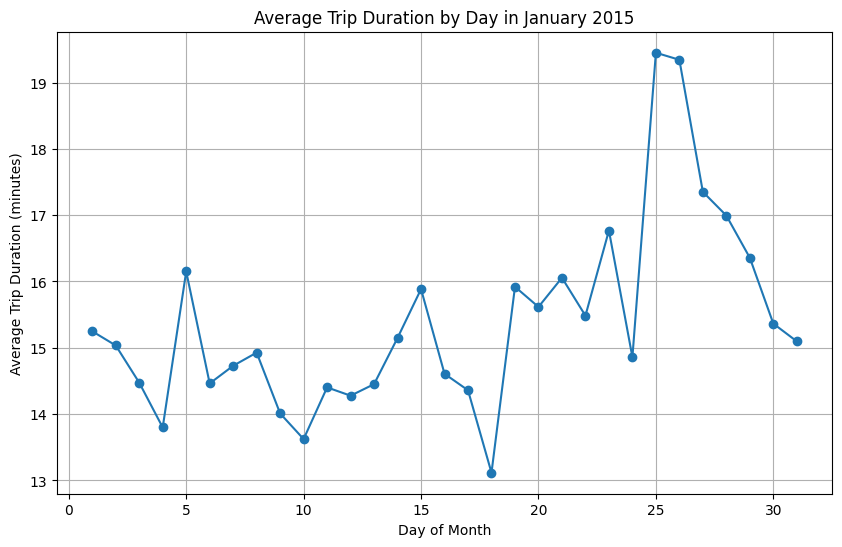

In [0]:
import matplotlib.pyplot as plt

df_cleaned.select("pickup_datetime").agg({"pickup_datetime": "min", "pickup_datetime": "max"}).show()

#since max pickup date is 31st jan 2015 , we will do how how the trip duration changes over each day of january

from pyspark.sql.functions import dayofmonth

# dayofmonth
df_cleaned = df_cleaned.withColumn("pickup_day", dayofmonth(col("pickup_datetime")))

# grouping by day
df_duration_by_day = df_cleaned.groupBy("pickup_day").agg(avg("trip_duration_min").alias("avg_trip_duration"))
df_duration_by_day = df_duration_by_day.orderBy("pickup_day")

# pandas df
df_duration_by_day_pd = df_duration_by_day.toPandas()

# plot
plt.figure(figsize=(10,6))
plt.plot(df_duration_by_day_pd["pickup_day"], df_duration_by_day_pd["avg_trip_duration"], marker='o')
plt.title("Average Trip Duration by Day in January 2015")
plt.xlabel("Day of Month")
plt.ylabel("Average Trip Duration (minutes)")
plt.grid(True)
plt.show()

4. Hourly Analysis: Check how the trip duration varies throughout the day. Plot the results


+-----------+------------------+
|pickup_hour| avg_trip_duration|
+-----------+------------------+
|          0|16.048029670300355|
|          1|15.028691911907591|
|          2|15.141004439437213|
|          3| 15.33576196403454|
|          4| 15.72814459987524|
|          5| 14.09508480107383|
|          6| 14.51208565404691|
|          7|13.809829439968702|
|          8|14.970002014479288|
|          9| 15.06214871141756|
|         10|15.246203973783643|
|         11|15.532871129034785|
|         12|15.544818900470098|
|         13|15.446571334395793|
|         14| 16.50711371636497|
|         15|16.874639041729836|
|         16|16.839945619194296|
|         17|16.542503574711148|
|         18| 15.49911251140422|
|         19|14.426846513304993|
+-----------+------------------+
only showing top 20 rows


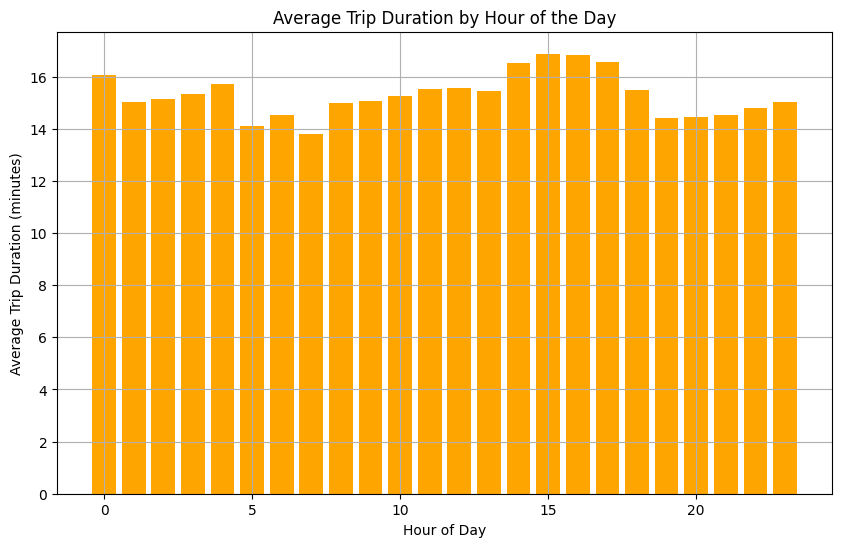

In [0]:
# Group by hour and calculate the average trip duration
df_duration_by_hour = df_cleaned.groupBy("pickup_hour").agg(avg("trip_duration_min").alias("avg_trip_duration"))

# Order the results by hour
df_duration_by_hour = df_duration_by_hour.orderBy("pickup_hour")

# Show the result
df_duration_by_hour.show()

# Convert the result to Pandas DataFrame for plotting
df_duration_by_hour_pd = df_duration_by_hour.toPandas()

# Plot the average trip duration by hour of the day
plt.figure(figsize=(10,6))
plt.bar(df_duration_by_hour_pd["pickup_hour"], df_duration_by_hour_pd["avg_trip_duration"], color='orange')
plt.title("Average Trip Duration by Hour of the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Trip Duration (minutes)")
plt.grid(True)
plt.show(5)

5.Identify Hotspots:

In [0]:
from pyspark.sql.functions import count

# Create 'pickup_location' and 'dropoff_location' in new dataframe
df_hotspots = df_cleaned.select("pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude").toPandas()
df_hotspots['pickup_location'] = df_hotspots.apply( lambda row: f"{row['pickup_longitude']}, {row['pickup_latitude']}", axis=1)
df_hotspots['dropoff_location'] = df_hotspots.apply( lambda row: f"{row['dropoff_longitude']}, {row['dropoff_latitude']}", axis=1)

# Display Pickup hotspots
pickup_hotspots = df_hotspots.groupby('pickup_location').size().reset_index(name='trip_count').sort_values(by='trip_count', ascending=False)
display(pickup_hotspots)

# Display dropoff hotspots
dropoff_hotspots = df_hotspots.groupby('dropoff_location').size().reset_index(name='trip_count').sort_values(by='trip_count', ascending=False)
display(dropoff_hotspots)

pickup_location trip_count -73.95466613769531, 40.82100296020508 1019 -73.86331939697266, 40.76948547363281 491 -73.79402923583984, 40.656707763671875 123 -73.87445831298828, 40.774051666259766 91 -73.87448120117188, 40.774070739746094 90 -73.87088775634766, 40.77376174926758 87 -73.87444305419922, 40.77402877807617 84 -73.87449645996094, 40.774070739746094 84 -73.8708724975586, 40.773738861083984 81 -73.87447357177734, 40.774070739746094 79 -73.77670288085938, 40.64537048339844 78 -73.77670288085938, 40.645408630371094 77 -73.87448120117188, 40.7740592956543 77 -73.87449645996094, 40.77408981323242 77 -73.87088775634766, 40.77376937866211 76 -73.8708724975586, 40.77376174926758 76 -73.87451934814453, 40.77410888671875 76 -73.87088775634766, 40.773738861083984 75 -73.87445068359375, 40.774051666259766 75 -73.87451171875, 40.77408981323242 75 -73.87447357177734, 40.774051666259766 74 -73.96461486816406, 40.76420211791992 73 -73.87451171875, 40.77410125732422 73 -73.87084197998047, 40.773738861083984 73 -73.99407196044922, 40.75122833251953 72 -73.87451934814453, 40.774078369140625 72 -73.87448120117188, 40.774078369140625 71 -73.87445068359375, 40.77402877807617 70 -73.87093353271484, 40.77378845214844 69 -73.87454986572266, 40.77410888671875 69 -73.87444305419922, 40.774051666259766 68 -73.87085723876953, 40.773738861083984 68 -73.870849609375, 40.773738861083984 68 -73.8708724975586, 40.77376937866211 68 -73.77667999267578, 40.645389556884766 67 -73.77670288085938, 40.645389556884766 67 -73.87449645996094, 40.774078369140625 67 -73.87444305419922, 40.774009704589844 67 -73.87448120117188, 40.774051666259766 67 -73.8744888305664, 40.77408981323242 66 -73.87451934814453, 40.77408981323242 66 -73.87088775634766, 40.77378845214844 66 -73.87091064453125, 40.77376174926758 65 -73.8744888305664, 40.774070739746094 65 -73.77667999267578, 40.64537048339844 65 -73.87447357177734, 40.77404022216797 64 -73.77671813964844, 40.645389556884766 64 -73.87445831298828, 40.77402877807617 64 -73.87093353271484, 40.77376937866211 64 -73.87452697753906, 40.77410125732422 64 -73.87452697753906, 40.77410888671875 64 -73.8708724975586, 40.77375030517578 63 -73.99410247802734, 40.75117874145508 63 -73.87084197998047, 40.77373123168945 63 -73.77667999267578, 40.645408630371094 63 -73.87091064453125, 40.77378845214844 62 -73.87445831298828, 40.77404022216797 62 -73.87457275390625, 40.77410125732422 62 -73.87088775634766, 40.773780822753906 62 -73.77668762207031, 40.64537811279297 62 -73.77670288085938, 40.64533996582031 62 -73.87085723876953, 40.773719787597656 61 -73.87451934814453, 40.774070739746094 61 -73.60540008544922, 40.758811950683594 61 -73.87457275390625, 40.77412033081055 61 -73.87091064453125, 40.773738861083984 61 -73.99408721923828, 40.75120162963867 60 -73.87451934814453, 40.77410125732422 60 -73.8708724975586, 40.773719787597656 60 -73.87093353271484, 40.77376174926758 60 -73.7767105102539, 40.64537048339844 60 -73.87085723876953, 40.77376937866211 59 -73.87449645996094, 40.77410125732422 59 -73.87091064453125, 40.77375030517578 59 -73.99407196044922, 40.75120162963867 59 -73.87442779541016, 40.77402877807617 59 -73.99407958984375, 40.75120162963867 59 -73.7767105102539, 40.64537811279297 58 -73.8708724975586, 40.77378845214844 58 -73.77671813964844, 40.645408630371094 58 -73.77668762207031, 40.645408630371094 58 -73.87444305419922, 40.77399826049805 58 -73.87081909179688, 40.77373123168945 58 -73.87091064453125, 40.77376937866211 58 -73.87088012695312, 40.77376174926758 58 -73.77671813964844, 40.645328521728516 58 -73.77671813964844, 40.64537048339844 58 -73.77670288085938, 40.645301818847656 58 -73.87445068359375, 40.77404022216797 57 -73.87447357177734, 40.77406311035156 57 -73.77670288085938, 40.64537811279297 57 -73.87451171875, 40.774078369140625 57 -73.8708724975586, 40.77373123168945 57 -73.99278259277344, 40.7581901550293 57 -73.87090301513672, 40.77376174926758 57 -73.87444305419922, 40.77402114868164 57 -73.9941177368164, 40.

Databricks visualization. Run in Databricks to view.

dropoff_location trip_count -73.95466613769531, 40.82100296020508 1019 -73.86331939697266, 40.76948547363281 489 -73.79402923583984, 40.656707763671875 123 -73.96461486816406, 40.76420211791992 71 -73.60540008544922, 40.758811950683594 61 -73.99278259277344, 40.7581901550293 57 -74.10140991210938, 40.683868408203125 47 -73.88459777832031, 40.84844970703125 47 -74.1011962890625, 40.68394088745117 46 -73.91673278808594, 40.83734893798828 45 -74.10526275634766, 40.68178176879883 45 -74.1050033569336, 40.681758880615234 44 -73.92227935791016, 40.776039123535156 43 -74.00418853759766, 40.74909973144531 43 -73.86178588867188, 40.90055847167969 43 -73.93830871582031, 40.758419036865234 43 -74.1036376953125, 40.68122100830078 43 -73.9267578125, 40.730369567871094 43 -73.884033203125, 40.86676025390625 42 -73.91840362548828, 40.783531188964844 40 -73.95662689208984, 40.76308822631836 39 -73.92543029785156, 40.77302551269531 38 -73.8695297241211, 40.772579193115234 37 -73.9946517944336, 40.75043869018555 37 -74.00276947021484, 40.76057815551758 36 -73.96709442138672, 40.762794494628906 36 -73.96537780761719, 40.79193115234375 36 -73.98551177978516, 40.77846908569336 35 -73.9805679321289, 40.76423645019531 35 -74.10504913330078, 40.68151092529297 35 -73.9258804321289, 40.807861328125 35 -73.91726684570312, 40.83523178100586 35 -73.86100006103516, 40.90088653564453 35 -73.92900848388672, 40.74665069580078 34 -74.0069580078125, 40.728919982910156 34 -73.75630950927734, 40.716278076171875 34 -73.98110961914062, 40.7417106628418 34 -73.97472381591797, 40.79050827026367 34 -73.75556945800781, 40.7156982421875 33 -73.93726348876953, 40.745601654052734 33 -73.9476089477539, 40.77035140991211 33 -73.98313903808594, 40.7421989440918 33 -73.75569152832031, 40.715877532958984 33 -73.98919677734375, 40.773223876953125 33 -73.91783142089844, 40.783329010009766 33 -73.86177825927734, 40.76839828491211 33 -73.99488830566406, 40.75014114379883 32 -73.9778823852539, 40.59645080566406 32 -74.0027084350586, 40.760650634765625 32 -73.97589874267578, 40.7518310546875 32 -73.95552062988281, 40.772640228271484 32 -73.95386505126953, 40.78190612792969 31 -73.79423522949219, 40.65646743774414 31 -73.9946517944336, 40.750431060791016 31 -74.00273132324219, 40.760650634765625 31 -73.76676940917969, 40.726375579833984 31 -74.00273132324219, 40.7606201171875 31 -73.86177825927734, 40.768409729003906 31 -73.91770935058594, 40.83475112915039 31 -73.9946517944336, 40.75041961669922 31 -73.98908996582031, 40.72154235839844 31 -73.87952423095703, 40.77048110961914 31 -73.93683624267578, 40.764705657958984 31 -73.96668243408203, 40.79410171508789 31 -73.99376678466797, 40.75693893432617 31 -74.00279235839844, 40.76055908203125 31 -73.99466705322266, 40.75046157836914 30 -73.98035430908203, 40.75436019897461 30 -73.96370697021484, 40.777095794677734 30 -74.0028076171875, 40.7605094909668 30 -74.00276947021484, 40.7606086730957 30 -73.91712188720703, 40.78289031982422 30 -73.79342651367188, 40.6571044921875 30 -73.8658676147461, 40.677734375 30 -73.99471282958984, 40.75035858154297 29 -73.97892761230469, 40.638118743896484 29 -74.00286102294922, 40.76049041748047 29 -73.9441146850586, 40.74980545043945 29 -74.00274658203125, 40.7606086730957 29 -73.99372100830078, 40.73579025268555 29 -73.99178314208984, 40.733489990234375 29 -73.94034576416016, 40.68819808959961 29 -73.95780944824219, 40.816951751708984 29 -74.00277709960938, 40.76057815551758 28 -73.99131774902344, 40.750221252441406 28 -74.00318145751953, 40.75965118408203 28 -73.96248626708984, 40.76219177246094 28 -73.9946517944336, 40.75040817260742 28 -74.00276947021484, 40.76060104370117 28 -73.86174774169922, 40.76839828491211 28 -73.91789245605469, 40.78330993652344 28 -74.09699249267578, 40.68497848510742 28 -74.10112762451172, 40.68389892578125 28 -74.10507202148438, 40.68157958984375 28 -73.98265838623047, 40.74232864379883 28 -74.0028076171875, 40.76055908203125 28 -73.75702667236328, 40.71796798706055 28 -73.

Databricks visualization. Run in Databricks to view.

6. Average Fair by Location:

In [0]:
import pandas as pd
# Create 'pickup_location'
df_locations = df_cleaned.select("pickup_longitude", "pickup_latitude", "fare_amount").toPandas()
df_locations['pickup_location'] = df_locations.apply(lambda row: f"({row['pickup_longitude']}, {row['pickup_latitude']})", axis=1)
df_locations['fare_amount'] = pd.to_numeric(df_locations['fare_amount'], errors='coerce')

# Find average fare based on pickup location
avg_fare_by_location = df_locations.groupby('pickup_location')['fare_amount'].mean().reset_index()
avg_fare_by_location.columns = ['Pickup Location', 'Average Fare Amount']

# Display results
display(avg_fare_by_location)

Pickup Location Average Fare Amount (-0.13990700244903564, 40.74379348754883) 7.0 (-100.81626892089844, 13.747817039489746) 5.0 (-100.82293701171875, 13.7465238571167) 5.0 (-25.86806297302246, 39.95017623901367) 6.0 (-46.61882019042969, 7.478622913360596) 35.5 (-51.99369812011719, 46.60777282714844) 10.0 (-56.42097854614258, 46.48027038574219) 9.0 (-57.270904541015625, 34.001041412353516) 7.0 (-61.22623825073242, 39.75065612792969) 8.0 (-61.33552932739258, 37.851051330566406) 12.0 (-64.84098052978516, 33.68185043334961) 6.5 (-65.75370788574219, 41.16621017456055) 9.5 (-65.80343627929688, 39.364356994628906) 18.0 (-65.89738464355469, 39.457881927490234) 8.472222222222221 (-65.93006134033203, 41.30241775512695) 9.0 (-65.98665618896484, 46.45309829711914) 19.5 (-66.332275390625, 31.760881423950195) 13.5 (-66.56527709960938, 42.179813385009766) 11.5 (-66.73580932617188, 60.908756256103516) 16.5 (-66.82946014404297, 34.73419952392578) 10.5 (-67.69007110595703, 42.737632751464844) 6.5 (-67.85457611083984, 33.712772369384766) 7.5 (-67.87246704101562, 40.86899948120117) 8.357142857142858 (-68.29531860351562, 15.26369571685791) 10.0 (-68.37248229980469, 43.28938293457031) 36.0 (-68.77843475341797, 36.11853790283203) 10.807692307692308 (-68.80785369873047, 36.1460075378418) 8.0 (-68.87366485595703, 32.60333251953125) 41.0 (-69.29460906982422, 42.35185623168945) 6.0 (-69.32820892333984, 41.49160385131836) 15.0 (-69.32914733886719, 40.3062858581543) 28.5 (-69.38845825195312, 35.09263229370117) 10.0 (-69.49239349365234, 41.2783088684082) 18.5 (-69.66927337646484, 41.82435989379883) 71.5 (-69.70938110351562, 35.942562103271484) 13.5 (-69.75786590576172, 37.60575866699219) 6.5 (-69.79143524169922, 42.622188568115234) 10.0 (-70.26776885986328, 36.42024230957031) 12.0 (-70.50540924072266, 40.39794921875) 10.5 (-70.97502899169922, 38.740028381347656) 8.0 (-71.16683197021484, 42.67464065551758) 11.681818181818182 (-71.47010040283203, 30.84800910949707) 8.5 (-71.53759002685547, 38.047767639160156) 9.75 (-71.5848617553711, 33.230308532714844) 9.9375 (-71.79989624023438, 35.0815315246582) 9.0 (-71.89386749267578, 39.20022964477539) 8.5 (-71.91895294189453, 41.044097900390625) 100.0 (-71.98653411865234, 40.3240852355957) 8.5 (-72.08049774169922, 32.94989013671875) 30.5 (-72.11270904541016, 31.887340545654297) 4.5 (-72.1886978149414, 46.692893981933594) 52.0 (-72.29352569580078, 42.9303092956543) 9.2 (-72.4298095703125, 39.51836013793945) 15.5 (-72.52947235107422, 38.47233963012695) 10.0 (-72.54743194580078, 40.40947341918945) 6.0 (-72.68374633789062, 38.51802062988281) 8.961538461538462 (-72.82571411132812, 42.994476318359375) 29.5 (-72.9242935180664, 41.28763961791992) 2.5 (-72.92762756347656, 41.30227279663086) 3.5 (-72.93408203125, 41.305885314941406) 20.0 (-72.93408966064453, 41.30588912963867) 250.0 (-73.03445434570312, 40.820045471191406) 58.5 (-73.07010650634766, 40.881561279296875) 250.0 (-73.08348083496094, 40.83210372924805) 425.0 (-73.09552764892578, 40.77959442138672) 245.5 (-73.09683990478516, 40.75885009765625) 242.0 (-73.11678314208984, 40.874366760253906) 150.0 (-73.12734985351562, 40.91033172607422) 250.0 (-73.16739654541016, 41.8618049621582) 10.5 (-73.18472290039062, 40.79448318481445) 162.0 (-73.18831634521484, 40.791446685791016) 32.5 (-73.19674682617188, 41.218570709228516) 400.0 (-73.20806121826172, 38.20000457763672) 36.5 (-73.20950317382812, 40.757450103759766) 9.421052631578947 (-73.21000671386719, 40.76116180419922) 47.333333333333336 (-73.22118377685547, 41.185813903808594) 132.25 (-73.22856140136719, 40.73957824707031) 19.5 (-73.23705291748047, 40.80624771118164) 180.0 (-73.25371551513672, 41.21426773071289) 260.0 (-73.2812728881836, 40.7286491394043) 52.0 (-73.28752136230469, 40.782718658447266) 170.0 (-73.2956314086914, 41.14064025878906) 210.0 (-73.32154083251953, 40.702392578125) 225.0 (-73.3238525390625, 40.820369720458984) 45.0 (-73.3306884765625, 40.82904052734375) 100.0 (-73.33091735839844, 40.70024108886719) 2.5

Databricks visualization. Run in Databricks to view.

7. Correlation Analysis

Correlation between trip duration and trip distance: 0.00015199150349164134
Correlation between trip duration and fare amount: 0.0304435744361142


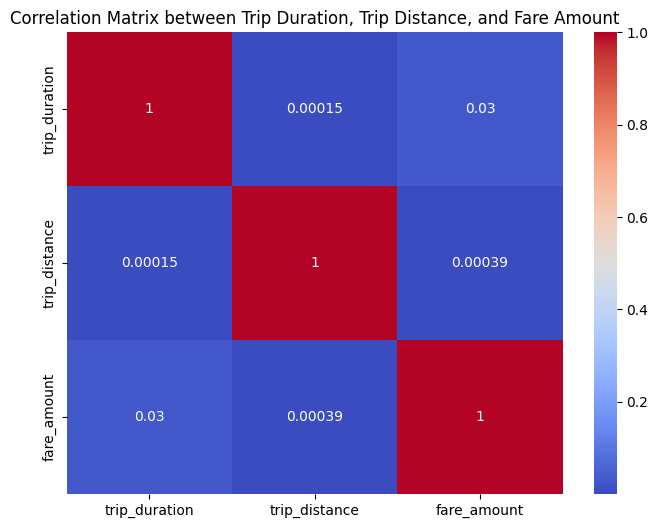

In [0]:
import seaborn as sns# Calculate trip duration in minutes

df = df.withColumn('trip_duration', 
                   ((col('tpep_dropoff_datetime').cast('long') - col('tpep_pickup_datetime').cast('long')) / 60).cast('double'))

# Convert columns to double type for consistency
df = df.withColumn('trip_distance', col('trip_distance').cast('double'))
df = df.withColumn('fare_amount', col('fare_amount').cast('double'))

# Filter out rows with null values in key columns
df = df.filter((col('trip_duration').isNotNull()) & 
               (col('trip_distance').isNotNull()) & 
               (col('fare_amount').isNotNull()))

# Calculate correlations
correlation = df.stat.corr('trip_duration', 'trip_distance')
fare_correlation = df.stat.corr('trip_duration', 'fare_amount')

# Print correlation results
print(f"Correlation between trip duration and trip distance: {correlation}")
print(f"Correlation between trip duration and fare amount: {fare_correlation}")

# Create a pandas DataFrame and correlation matrix
corr_df = df.select('trip_duration', 'trip_distance', 'fare_amount').toPandas()
corr_matrix = corr_df.corr()

# Plot the correlation matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix between Trip Duration, Trip Distance, and Fare Amount')
plt.show()


The trip duration and fare amount have a correlation (since how long the trip takes will influence the fare). The fare amount also has a correlation to trip distance (which also makes sense for the same reason. Trip distance and trip duration have the least correlation (which is likely influenced by traffic).

8. Examine taxi demand

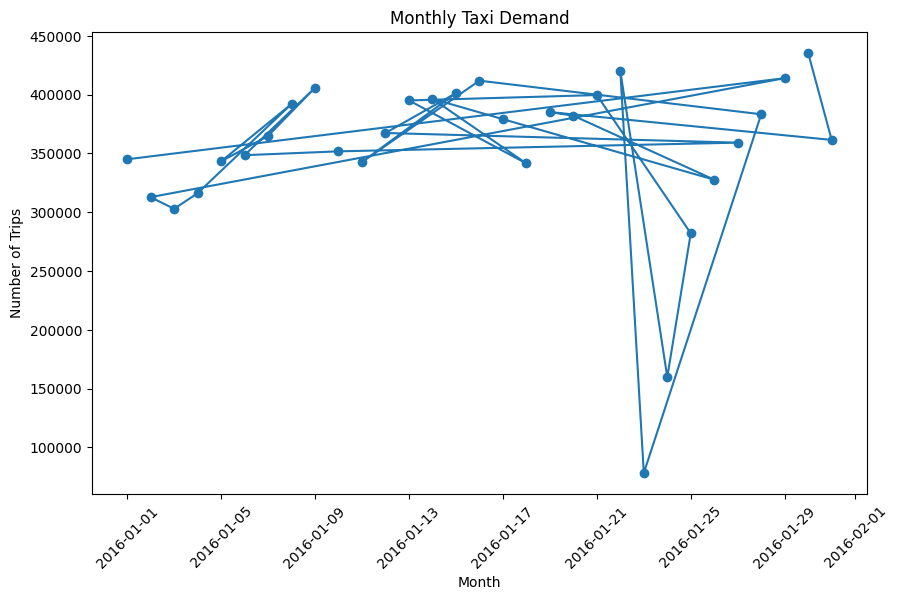

In [0]:
# Cast pickup datetime column to timestamp type
df = df.withColumn('tpep_pickup_datetime', df['tpep_pickup_datetime'].cast('timestamp'))

# Extract the pickup month (date) from the pickup datetime
df = df.withColumn('pickup_month', df['tpep_pickup_datetime'].cast('date'))

# Group by pickup month and count the number of trips per month
monthly_trips = df.groupby('pickup_month').count()

# Convert the grouped data to pandas for plotting
plt.figure(figsize=(10, 6))
monthly_trips_df = monthly_trips.toPandas()

# Plot the number of trips by month
plt.plot(monthly_trips_df['pickup_month'], monthly_trips_df['count'], marker='o')
plt.title('Monthly Taxi Demand')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()

Taxi demand appears to be at its highest near the middle of the month (days 14-18), and in the last day of the month, and seems low at start of the month (days 1-5), and at its lowest on the 27th.